### Demonstration of how to connect to API and submit

This notebook is to demonstrate the usage of the API for a workshop participant

(i.e.: someone with no access to the ground-thruth of the Fraud data)

- Submitting predictions to API
- Collecting the previous predictions

For admin/organizer usage: how to add/delete users and their labels


In [10]:
import os
import requests
import pickle
import json
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import scale as preproc_scale

from sklearn.ensemble import IsolationForest
import numpy as np
from sklearn.metrics import roc_auc_score


In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
from outlierutils import median_imputation, LabelSubmitter, plot_outlier_scores, plot_top_N

In [5]:
X_FRAUD_PATH = 'data/x_fraud.pkl'
X_PEN_PATH = 'data/x_pendigits.pkl'
Y_PEN_PATH = 'data/y_pendigits.pkl'
# Y_DATA_PATH = 'data/y_fraud.pkl'

## Load data

In [7]:
x_fraud = pd.read_pickle(X_FRAUD_PATH)
x_pen = pd.read_pickle(X_PEN_PATH) 
y_pen = pd.read_pickle(Y_PEN_PATH)


## Prepare data
#### 1) Fraud data

Convert V-columns

In [8]:
column_groups = {'card': [c for c in x_fraud.columns if c.startswith('card')],
                   'addr': [c for c in x_fraud.columns if c.startswith('addr')],
                   'dist1': ['dist1', 'dist2'],
                   'C' : [c for c in x_fraud.columns if c.startswith('C')],
                   'D' : [c for c in x_fraud.columns if c.lstrip('D').isnumeric()],
                   'M' : [c for c in x_fraud.columns if c.startswith('M')],
                   'id' : [c for c in x_fraud.columns if c.startswith('id')],   
                   'V': [c for c in x_fraud.columns if c.startswith('V')],
                   'trans': [c for c in x_fraud.columns if c.startswith('Trans')]}


In [11]:
V_original = median_imputation(x_fraud[column_groups['V']], median_impute_limit=0)
V_original = preproc_scale(V_original)

#### 2) Pendigits --needs no preproc --

## Outlier detection
### 1) Fraud data

In [12]:
ifo = IsolationForest(n_estimators=50, max_samples=512)
ifo.fit(V_original)
fraud_scores = - ifo.decision_function(V_original)


In [13]:
# Select the top-1000 
N = 1000
top_N_fraud = np.argsort(fraud_scores)[::-1][:N]
top_N_fraud_scores = fraud_scores[top_N_fraud]

### 2) Pen digits data

In [14]:
ifo = IsolationForest(n_estimators=50, max_samples=512)
ifo.fit(x_pen)
pen_scores = - ifo.decision_function(x_pen)

In [15]:
# Select the top-500 
N = 500
top_N_pen = np.argsort(pen_scores)[::-1][:N]
top_N_pen_scores = pen_scores[top_N_pen]

####  Small interlude: plot some curves to see how well the algorithm performs

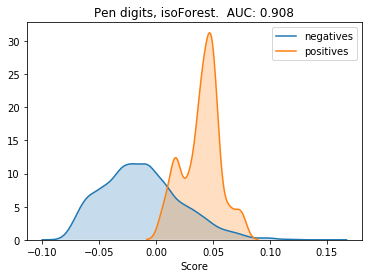

In [16]:
res = plot_outlier_scores(y_pen.values, pen_scores, bw=0.005, title='Pen digits, isoForest. ')

In [17]:
'{:.3%}'.format(y_pen.mean())

'0.203%'

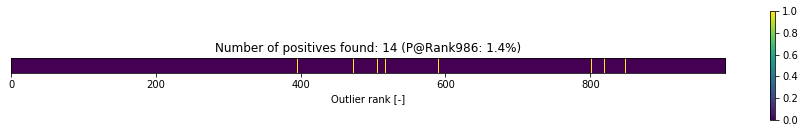

In [18]:
res = plot_top_N(y_pen.values, pen_scores, N=int(0.1*len(pen_scores)))

## Submit to API

#### "Front-end" Class definition

In [20]:
import functools

def admin_only(func):
    """ Decorator for "dangerous" functions
    """
    @functools.wraps(func)
    def wrapper_decorator(*args, **kwargs):
        if not args[0].username == 'admin': #NB: first arg to an object-method is self
            print('Admin only!')
            return None
        if not kwargs.get('iknowwhatiamdoing', None):
            print('pass iknowwhatiamdoing=True to execute this')
            return None
        value = func(*args, **kwargs)
        return value
    return wrapper_decorator

class LabelSubmitter():
    def __init__(self, username, password, url='http://127.0.0.1:5000'):
        self.username = username
        self.password = password
        self.jwt_token = None
        self.base_url = url
        self.last_labels = None
        self.all_labels = None
    
    def get_jwt_token(self):
        """ Posts to /auth
        """
        auth = requests.post(self.base_url + '/auth', json={"username": f"{self.username}",
                "password": f"{self.password}"})
        try:
            self.jwt_token = json.loads(auth.text)['access_token']
        except KeyError:
            return auth
    
    def post_predictions(self, idx, endpoint='pen'):
        """ Posts to /label
        sets self.last_labels
        """
        idx = [int(n) for n in idx] # replace numpy array and int64 by list with ints
        res = requests.post(url=self.base_url + '/label/{}'.format(endpoint), 
                    json={'data': {'idx': idx}},
                   headers={'Authorization': 'JWT {}'.format(self.jwt_token)})
        self.res = res
        try:
            result = json.loads(res.text)['result']
            unzips = list(zip(*result))
            labels = pd.Series(index=unzips[0], data=unzips[1]).sort_index()
            self.last_labels = labels 
            
            print(json.loads(res.text)['info'])
            print('number of positives in submission: {:d}'.format(int(labels.sum())))
            print('precision of submission: {:.2%}'.format(labels.mean()))
        except Exception:
            print(json.loads(res.text))
        
    def get_labels(self, endpoint='pen'):
        """ 'Gets' to /label
        sets self.all_labels
        """
        try:
            res = requests.get(url=self.base_url + '/label/{}'.format(endpoint), 
                       headers={'Authorization': 'JWT {}'.format(self.jwt_token)}) 
            result = json.loads(res.text)['result']
            unzips = list(zip(*result))
            labels = pd.Series(index=unzips[0], data=unzips[1]).sort_index()
            self.all_labels = labels
            print('number of predictions made: {:d}'.format(int(len(labels))))
            print('total number of positives found: {:d}'.format(int(labels.sum())))
            print('total precision: {:.2%}'.format(labels.mean()))
            return labels
        except Exception:
            print(json.loads(res.text))
            
    def get_statistics(self, endpoint='pen', plot=True):
        res = requests.get(url=self.base_url + '/labelstats/{}'.format(endpoint), 
           headers={'Authorization': 'JWT {}'.format(self.jwt_token)}) 
        stats = json.loads(res.text)['result']
        stats_df = pd.DataFrame.from_dict(stats).T
        stats_df['precision'] = 100 * stats_df['N_positives_found'] / stats_df['N_submitted']
        if plot:
            fig, axs = plt.subplots(2, 1, figsize=(12,6))
            stats_df['N_submitted'].plot(kind='bar', ax=axs[0])
            stats_df['precision'].plot(kind='bar', ax=axs[1])
            axs[0].set_title('Number of submitted points')
            axs[1].set_title('Precision [%]')
            plt.tight_layout()
        return stats_df
    
    def add_user(self, username, password):
        res = requests.post(url=self.base_url + '/newuser', 
           headers={'Authorization': 'JWT {}'.format(self.jwt_token)},
            json={'username': username,
                          'password': password}
                           ) 
        print(json.loads(res.text))
        
    @admin_only
    def delete_user(self, username, iknowwhatiamdoing=False):
        res = requests.delete(url=self.base_url + '/removeuser/{}'.format(username), 
           headers={'Authorization': 'JWT {}'.format(self.jwt_token)}) 
        print(json.loads(res.text))
        
    @admin_only
    def delete_labels(self, username, endpoint='pen'):
        res = requests.delete(url=self.base_url + '/labeladmin/{}'.format(username), 
           headers={'Authorization': 'JWT {}'.format(self.jwt_token)}) 
        print(json.loads(res.text))


## Submitting at heroku

In [25]:
url = "https://unsupervised-label-api-pg.herokuapp.com/"
#url = 'http://127.0.0.1:5000' #localhost


** Start with submitting to 'pendigits'

**1.** Test submission by organizer to pendigits endpoint

In [26]:
ls_remote = LabelSubmitter(username='ernst', 
                           password='2718_', 
                           url=url)
ls_remote.get_jwt_token()

In [27]:
ls_remote.post_predictions(top_N_pen, endpoint='pen')

submitted 0 new points
number of positives in submission: 6
precision of submission: 1.20%


**2.** Test that upon 2nd submission, 0 new points are reported, but same stats

In [28]:
ls_remote.post_predictions(top_N_pen, endpoint='pen')

submitted 0 new points
number of positives in submission: 6
precision of submission: 1.20%


**3.** Test retrieval of submitted labels

In [29]:
pen_labels = ls_remote.get_labels(endpoint='pen')

number of predictions made: 1040
total number of positives found: 10
total precision: 0.96%


**4.** Submit for other user, to pendigits

In [30]:
ls_remote = LabelSubmitter(username='test', 
                           password='2718_', 
                           url=url)
ls_remote.get_jwt_token()
ls_remote.post_predictions(top_N_pen[:200], endpoint='pen')

submitted 72 new points
number of positives in submission: 1
precision of submission: 0.50%


**5.** Submit  for 'fraud' **

In [31]:
ls_remote.post_predictions(top_N_fraud, endpoint='fraud')

submitted 277 new points
number of positives in submission: 221
precision of submission: 22.10%


In [32]:
fraud_labels = ls_remote.get_labels(endpoint='fraud')

number of predictions made: 1277
total number of positives found: 321
total precision: 25.14%


**6.** Plotting statistics *(NB: only for admin or workshop organizers: plotting statistics)*

,N_positives_found,N_submitted,precision
admin,0.0,0.0,NaN
steffen,0.0,0.0,NaN
alessandro,0.0,0.0,NaN
theo,0.0,0.0,NaN
giulio,0.0,0.0,NaN
ernst,10.0,1040.0,0.961538
test,1.0,272.0,0.367647


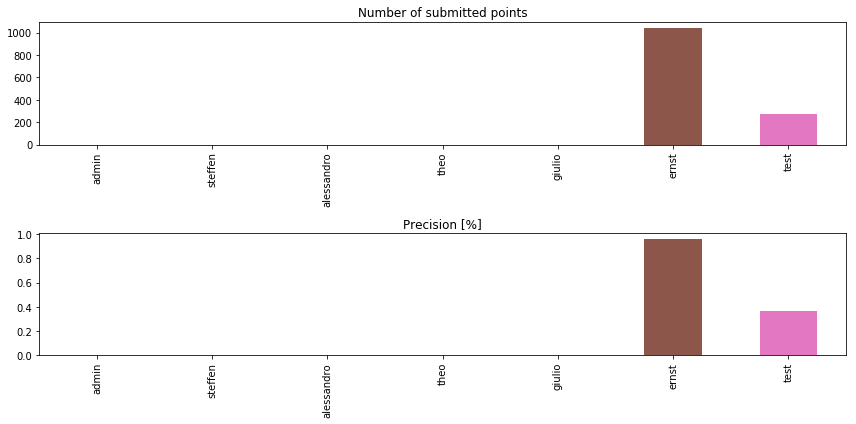

In [69]:
ls_remote.get_statistics(endpoint='pen')

** 6.** Add-users *(Admin only!)*

In [44]:
api_pwd = os.environ.get("api_admin_pw")

In [48]:
ls_admin = LabelSubmitter(username='admin', 
                           password=api_pwd, 
                           url=url)
ls_admin.get_jwt_token()
ls_admin.add_user(username='papacito', password='2345_')

{'message': 'User papacito created successfully.'}


** 7. ** Let Papacito do his thing and submit to "fraud"

In [51]:
ls_papacito = LabelSubmitter(username='papacito', 
                           password='2345_', 
                           url=url)

ls_papacito.get_jwt_token()

In [52]:
ls_papacito.post_predictions(top_N_fraud[-200:], endpoint='fraud')

submitted 200 new points
number of positives in submission: 49
precision of submission: 24.50%


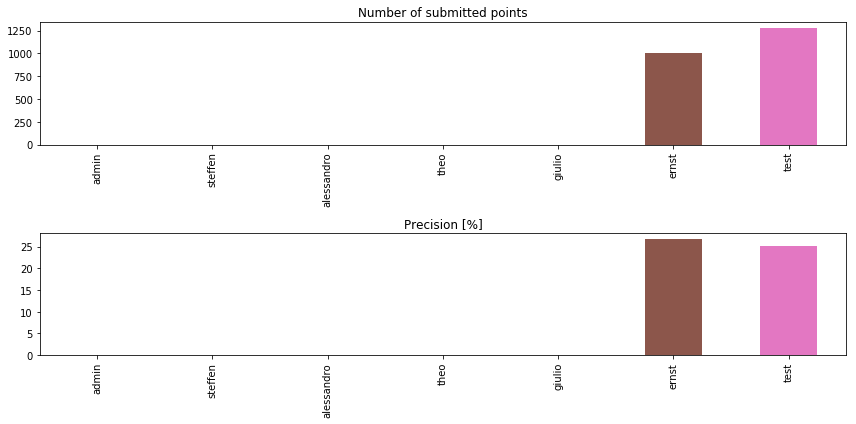

In [68]:
stats = ls_admin.get_statistics(endpoint='fraud')

** 8. ** Delete papacito and create another new user. This user should have no labels (clean-up of "orphaned" labels)

In [54]:
ls_admin.delete_user('papacito', iknowwhatiamdoing=True)

{'message': 'User papacito removed successfully.'}


In [55]:
ls_admin.add_user(username='mamacita', password='2345_')

{'message': 'User mamacita created successfully.'}


In [56]:
ls_mamacita = LabelSubmitter(username='mamacita', 
                           password='2345_', 
                           url=url)

ls_mamacita.get_jwt_token()
ls_mamacita.post_predictions(top_N_fraud[-120:], endpoint='fraud')

submitted 120 new points
number of positives in submission: 29
precision of submission: 24.17%


In [60]:
labels = ls_mamacita.get_labels(endpoint='fraud')

number of predictions made: 120
total number of positives found: 29
total precision: 24.17%


** 9. ** Try to add an existing user (should fail) [NB: the blocking in the class is merely an extra warning. It is also blocked in the API]

In [61]:
ls_admin.add_user(username='test', password='2345_')

{'message': 'user already exists'}


** 10. ** Try to delete a user as a non-admin (should fail)

In [62]:
ls_mamacita.delete_user('test')

Admin only!


In [63]:
ls_remote.delete_user('test')

Admin only!


** 11. ** Try to delete labels as a non-admin (should fail)

In [64]:
ls_mamacita.delete_labels('test')

Admin only!


** 12. Try to accidentally remove user/labels as admin (not passing iknowwhatiamdoing **


In [65]:
ls_admin.delete_labels(username='mamacita', endpoint='fraud')

pass iknowwhatiamdoing=True to execute this


In [66]:
ls_admin.delete_user(username='mamacita', endpoint='fraud')

pass iknowwhatiamdoing=True to execute this


### Clean-up

In [67]:
ls_admin.delete_user('papacito', iknowwhatiamdoing=True)
ls_admin.delete_user('mamacita', iknowwhatiamdoing=True)

{'message': 'user not found'}
{'message': 'User mamacita removed successfully.'}
